## **MODULAR REAL TIME MODELING FOR FINANCIAL INSIGHT GENERATION**

In [1]:
import requests
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from datetime import datetime
import time

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import cohere
import faiss
from tqdm import tqdm
import random

import praw
import re
from datasets import Dataset
import sys
from src.utils import clean_corpus, refine_corpus, news_pull
from src.scraping_module import *

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmanueladeleye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pulling all news source

In [2]:
logger.info("Starting the news pull")

scraper = UnifiedFinancialScraper(query="stocks")
result_df = scraper.fetch_all()
logger.info(f"Scraping complete | Total articles fetched: {len(result_df)}")
logger.info("Commencing cleaning and refining the corpus")
result_df['full_response'] = " Source: " + result_df['source'] + "\n" + result_df['title'] + '\n' + result_df['content']

texts_list = result_df['title'] + '\n' + result_df['content']

# Stack them all into a single string
all_text = "\n".join(texts_list)     
logger.info(f"News pull complete | Total articles fetched: {len(result_df)}")

2026-01-14 23:26:00,602 - INFO - Starting the news pull
Testing instances: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
2026-01-14 23:27:01,421 - ERROR - Error fetching from https://finance.yahoo.com/news/rssindex: object has no attribute 'summary'
2026-01-14 23:27:02,337 - INFO - Fetched 16 RSS articles
2026-01-14 23:28:42,067 - INFO - Fetched 100 Google News articles
2026-01-14 23:28:42,959 - INFO - Fetched 9 Finnhub articles
2026-01-14 23:28:43,463 - INFO - Fetched 0 Alpha Vantage articles
2026-01-14 23:28:44,120 - INFO - Fetched 100 NewsAPI articles
2026-01-14 23:28:49,956 - INFO - Fetched 150 Reddit posts
2026-01-14 23:28:49,958 - ERROR - Error fetching tweets for query 'stocks': Cannot choose from an empty sequence
2026-01-14 23:28:49,960 - INFO - Fetched 0 Twitter posts
2026-01-14 23:28:49,969 - INFO - Total articles before deduplication: 375
2026-01-14 23:28:50,021 - INFO - Total articles after deduplication: 193
2026-01-14 23:28:50,021 - INFO - Scraping complete | Total artic

                  title                                            content  \
81  Before you continue  We use cookies and data to\nDeliver and mainta...   
88  Before you continue  We use cookies and data to\nDeliver and mainta...   
86  Before you continue  We use cookies and data to\nDeliver and mainta...   
85  Before you continue  We use cookies and data to\nDeliver and mainta...   
84  Before you continue  We use cookies and data to\nDeliver and mainta...   

         source                 date  \
81  Google News  2026-01-14 17:06:42   
88  Google News  2026-01-14 13:40:35   
86  Google News  2026-01-14 22:32:04   
85  Google News  2026-01-10 19:03:00   
84  Google News  2026-01-14 14:35:00   

                                                  url  score  comments  \
81  https://news.google.com/rss/articles/CBMidkFVX...    NaN       NaN   
88  https://news.google.com/rss/articles/CBMiogFBV...    NaN       NaN   
86  https://news.google.com/rss/articles/CBMingFBV...    NaN       N

News source distribution

In [3]:
pd.Series(result_df["source"].value_counts())

source
NewsAPI                 42
Reddit r/investing      30
Reddit r/stocks         30
Reddit r/options        27
Reddit r/StockMarket    27
Reddit r/algotrading    15
Reddit r/fatFIRE        11
Reddit r/economics       6
Google News              3
ft_companies             1
CNBC                     1
Name: count, dtype: int64

In [8]:
# google news
result_df[result_df['source']=='Google News']["content"][1]

'We use cookies and data to\nDeliver and maintain Google services\nTrack outages and protect against spam, fraud, and abuse\nMeasure audience engagement and site statistics to understand how our services are used and enhance the quality of those services\nIf you choose to “Accept all,” we will also use cookies and data to\nDevelop and improve new services\nDeliver and measure the effectiveness of ads\nShow personalized content, depending on your settings\nShow personalized ads, depending on your settings\nIf you choose to “Reject all,” we will not use cookies for these additional purposes.\nNon-personalized content is influenced by things like the content you’re currently viewing, activity in your active Search session, and your location. Non-personalized ads are influenced by the content you’re currently viewing and your general location. Personalized content and ads can also include more relevant results, recommendations, and tailored ads based on past activity from this browser, lik

In [5]:
cleaned_corpus = refine_corpus(all_text)
logger.info(
    "Corpus refined | original=%d | cleaned=%d",
    len(all_text),
    len(cleaned_corpus)
)

2026-01-14 12:56:44,478 - INFO - Corpus refined | original=183247 | cleaned=937


#### **Search Option 1 - Cohere Embeddings**

In [6]:
load_dotenv()
cohere_api = os.getenv("cohere_api")
co = cohere.Client(cohere_api)
openai_api = os.getenv("openai_api")

In [7]:
def embed_with_backoff(texts, batch_size=90, sleep_time=1):
    embeddings = []
    total_texts = len(texts)
    logger.info("Starting embedding with backoff | total_texts=%d", total_texts)
    for i in tqdm(range(0, total_texts, batch_size)):
        batch_texts = texts[i:i+batch_size]
        success = False
        while not success:
            try:
                response = co.embed(texts=batch_texts, input_type='search_document')
                embeddings.extend(response.embeddings)
                success = True
                logger.info(f"Successfully embedded batch starting from {i} to {i+len(batch_texts)}")
                time.sleep(2) # to respect rate limiting
            except Exception as e:
                logger.warning("Embedding failed for batch starting at index %d: %s. Retrying after %d seconds.", i, str(e), sleep_time)
                time.sleep(sleep_time)
    return embeddings

def search(s_query, number_of_results):
    query_embed = embed_with_backoff([s_query])[0]
    query_vc_np = np.array([query_embed], dtype='float32')
    dimension = query_vc_np.shape[1]
    index = faiss.IndexFlatL2(dimension)
    corpus_embeddings = np.array(embed_with_backoff(cleaned_corpus), dtype='float32')
    index.add(corpus_embeddings)
    distances, similar_items_ids = index.search(query_vc_np, number_of_results)
    results_idx = similar_items_ids[0]
    results_dist = distances[0]

    results = pd.DataFrame({
        "text": np.array(cleaned_corpus)[results_idx],
        "distance": results_dist
    })
    print(f"Search complete | query='{s_query}' | results_returned={len(results)}")
    return results

In [8]:
search('Attack on Putin', 5)

2026-01-14 14:36:28,506 - INFO - Starting embedding with backoff | total_texts=1
  0%|          | 0/1 [00:00<?, ?it/s]2026-01-14 14:36:39,992 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2026-01-14 14:36:40,518 - INFO - Successfully embedded batch starting from 0 to 1
100%|██████████| 1/1 [00:13<00:00, 13.97s/it]
2026-01-14 14:36:42,539 - INFO - Starting embedding with backoff | total_texts=937
  0%|          | 0/11 [00:00<?, ?it/s]2026-01-14 14:36:43,551 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2026-01-14 14:36:45,200 - INFO - Successfully embedded batch starting from 0 to 90
  9%|▉         | 1/11 [00:04<00:46,  4.67s/it]2026-01-14 14:36:50,190 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2026-01-14 14:36:57,033 - INFO - Successfully embedded batch starting from 90 to 180
 18%|█▊        | 2/11 [00:16<01:19,  8.88s/it]2026-01-14 14:36:59,702 - INFO - HTTP Request: POST https://api.coh

Search complete | query='Attack on Putin' | results_returned=5


,text,distance
0,"With the US hitting Venezuela today, is anyone...",8731.802734
1,Source: I think stocks tomorrow will drop and...,9286.841797
2,Trump has also deployed U.S. troops to police ...,9741.483398
3,"Chevron, Exxon and SLB stocks jump after Trump...",9758.405273
4,After spending heavily to propel Trump back to...,9898.251953


#### **Search Option 2 - BM25 + Reranking**

In [11]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string

from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever

In [12]:
# similarity + keyword match
def bm25_tokenizer(text):
    tokenizer_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token)>0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenizer_doc.append(token)

    return tokenizer_doc

def keyword_and_reranking_search(s_query, top_k=5, num_candidates=10, bm25=None):
    print(f'Input Query: {s_query}')

    #### BM25 search lexical search
    bm25_scores = bm25.get_scores(bm25_tokenizer(s_query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]
    bm25_hits = [{'corpus_id':idx, 'score':bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f'Top-{top_k} Lexical Search (BM25) Hits')

    for hit in bm25_hits[0:top_k]:
        print('\t{:.3f}\t{}'.format(hit['score'], cleaned_corpus[hit['corpus_id']].replace('\n',' ')))

    # Adding reranking
    docs = [cleaned_corpus[hit['corpus_id']] for hit in bm25_hits]

    print(f'\nTop-{top_k} Hits By Rank-API ({len(bm25_hits)} BM25 Hits Re-Ranked)')
    results = co.rerank(query=s_query, documents=docs, top_n=top_k, return_documents=True)

    for hit in results.results:
        print('\t{:.3f}\t{}'.format(hit.relevance_score, hit.document.text.replace('\n','')))

In [13]:
tokenized_corpus = []
for passage in tqdm(cleaned_corpus):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)    

100%|██████████| 937/937 [00:00<00:00, 168109.46it/s]


In [14]:
keyword_and_reranking_search(s_query='China\'s position on US tarrifs', bm25=bm25)

Input Query: China's position on US tarrifs
Top-5 Lexical Search (BM25) Hits
	5.541	I realized I was taking on more risk than I fully understood, especially with position sizing.
	5.147	Position: Lots of VGLT to bet on rate cuts and QE pushing up bond pricesyields down.
	5.147	My account size and margin buffer are significantly larger than this position, so I am at zero risk of a margin call.
	4.971	Given the strong backlog and upbeat forward guidance, do you think this is a good time to start a position?
	4.806	Stock Crashes 40: I can buy back the short calls for profit and roll down to a lower strike to manage the position.

Top-5 Hits By Rank-API (10 BM25 Hits Re-Ranked)


2026-01-14 14:53:01,855 - INFO - HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"


	0.061	Position: Lots of VGLT to bet on rate cuts and QE pushing up bond pricesyields down.
	0.053	Given the strong backlog and upbeat forward guidance, do you think this is a good time to start a position?
	0.050	I realized I was taking on more risk than I fully understood, especially with position sizing.
	0.034	Reflecting on first quarter of collecting premiums Until this quarter, I have been largely avoiding options, thinking it is dangerous, but then I got into covered calls largely because I got tired of holding a large position that hasn't really moved for a while, and from there branching out into other strategies.
	0.032	I close or roll the position if I the stock falls to near or below the striking, or I have 80 profit, or the premium for the rest of the days is too low to hold.


#### **Search Option 3 - Implementing Langchain**

In [15]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

import openai

In [16]:
response_schemas = [
    ResponseSchema(name="key_insights", description='3-5 bullet points summarizing key insights/outlook on the topic'),
    ResponseSchema(name="key_drivers", description='Main economic/politcal indicators driving the topic'),
    ResponseSchema(name='risks', description='Potential risks associated with the topic'),
    ResponseSchema(name='sentiment', description='Overall social sentiment (positive/negative/neutral with evidence) and degree of sentiment in percentage')    
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [17]:
def analyze_text(s_query, relevant_text):
    
    # initiate llm model
    prompt = ChatPromptTemplate.from_template(
    """
    Analyze the following news corpus regarding {query} and extract:
    {format_instructions}
    
    Corpus:
    {text}
    
    """)
    #client = openai.OpenAI(api_key=openai_key)
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0.3,
        openai_api_key=openai_api  # Pass key directly or use environment variable
    )

    messages = prompt.format_messages(
        query = s_query,
        text = relevant_text,
        format_instructions=format_instructions
    )

    response = llm(messages)
    return output_parser.parse(response.content)

In [18]:
def create_search_index(full_text):
    # Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    chunks = text_splitter.split_text(full_text)

    # creating searchable index
    embeddings = OpenAIEmbeddings(openai_api_key=openai_api)
    return FAISS.from_texts(chunks, embeddings)    

def analyze_with_semantic_search(s_query, text_list, n_results=10):
    full_texts = " ".join(text_list) if isinstance(text_list, list) else text_list
    # creating vector index on full corpus
    index = create_search_index(full_texts)

    # retreiving relevant chunks
    bm25_retriever = BM25Retriever.from_texts(full_texts)
    faiss_retriever = index.as_retriever()
    ensemble_retriever = EnsembleRetriever(
        retrievers=[bm25_retriever, faiss_retriever], 
        weights=[0.4,0.6]
    )
    
    relevant_text = ensemble_retriever.get_relevant_documents(s_query)
    
    return analyze_text(s_query, relevant_text), relevant_text

#### **Testing**

Including social media

In [19]:
## reruning semantic search on data inclusive of reddit posts
s_query = 'Greenland and the global economy'
full_texts = cleaned_corpus
result, context = analyze_with_semantic_search(s_query, full_texts, n_results=5)

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4582/2881924575.py:10: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api)
2026-01-14 14:53:40,139 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4582/2881924575.py:26: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_text = ensemble_retriever.get_relevant_documents(s_query)
2026-01-14 14:53:42,137 - INFO - HTTP Request: POST https://api.ope

In [20]:
result

{'key_insights': "1. Economists revising growth predictions upward due to AI spending by U.S. tech industry. 2. US grid capacity shortages being addressed with heavy generators for Data Centres and AI Infrastructure. 3. Potential impact on China due to US actions in the energy sector. 4. Speculation on Trump's motivations for flooding global oil supply. 5. Gold trading at all-time highs with potential impact on global economies.",
 'key_drivers': "AI spending by U.S. tech industry, grid capacity shortages in the U.S., US actions in the energy sector, Trump's motivations in global oil supply, Gold trading at all-time highs.",
 'risks': "Potential risks include economic instability from US-China tensions, impact of grid capacity shortages on energy sector, and uncertainty surrounding Trump's oil supply manipulation.",
 'sentiment': 'Neutral. The corpus presents a mix of positive and negative factors impacting the global economy, with potential risks and uncertainties balanced by opportun

Excluding social media

In [21]:
pd.DataFrame(result_df["source"].value_counts())

,count
source,
NewsAPI,39
Reddit r/stocks,30
Reddit r/investing,30
Reddit r/options,27
Reddit r/StockMarket,27
Google News,11
Reddit r/fatFIRE,10
Reddit r/algotrading,8
Reddit r/economics,7


In [22]:
len(result_df)

190

In [23]:
full_response_no_reddit = result_df[result_df['source'].str.lower() != 'reddit r/wallstreetbets']
texts_list_no_reddit = full_response_no_reddit['title'] + '\n' + full_response_no_reddit['content']
all_text_no_reddit = "\n".join(texts_list_no_reddit)

In [24]:
## rerunning semantic search on data exclusive of reddit posts
cleaned_texts_no_reddit = refine_corpus(all_text_no_reddit)
result_2, context_2 = analyze_with_semantic_search(s_query, cleaned_texts_no_reddit, n_results=5)

2026-01-14 14:55:01,883 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-14 14:55:03,807 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-14 14:55:06,674 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [25]:
result_2

{'key_insights': "1. US grid capacity shortages are being addressed with heavy generators for Data Centers and AI Infrastructure. 2. Economists are revising growth predictions upward due to AI spending by the U.S. tech industry. 3. Global economy expected to grow 3.2% despite US trade war. 4. Trump's motivations in flooding global oil supply may impact global economies. 5. Speculation on crashing gold prices to reinforce the safety of the dollar.",
 'key_drivers': "US grid capacity shortages, AI spending by U.S. tech industry, global economic growth, Trump's oil supply manipulation, gold prices.",
 'risks': "Potential risks include overreliance on diesel and gas generators, impact of Trump's oil supply manipulation on global economies, and uncertainty in gold prices due to market manipulation.",
 'sentiment': "Neutral. The corpus presents a mix of positive and negative factors such as addressing grid capacity shortages and potential economic impacts of Trump's actions. Overall sentimen

#### **Evaluation**

In [26]:
from ragas import evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4582/3316452575.py:2: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4582/3316452575.py:2: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4582/3316452575.py:2: DeprecationWarning: Importing context_recall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.

In [81]:
financial_eval_data = {
    "question": [
        "How has the conflict affected the energy sector specifically?",
        "Which specific European indices showed the most resilience?"
    ],
    "sub_query": [
        "impact of Russia Ukraine war on oil and gas stocks 2023",
        "European stock market performance Russia war 2023 FTSE vs DAX"
    ],
    "ground_truth": [
        "Significant volatility in energy prices; windfall profits for global oil majors; shift in European energy dependency.",
        "FTSE 100 often outperformed due to commodity exposure; DAX faced pressure due to industrial energy costs."
    ]
}

In [82]:
results_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": []
}

full_texts = cleaned_corpus
for query in financial_eval_data['sub_query']:
    result, relevant_text = analyze_with_semantic_search(query, full_texts, n_results=5)
    results_data['question'].append(query)
    results_data['answer'].append(result['key_insights'])
    results_data['contexts'].append([doc.page_content for doc in relevant_text])
    results_data['ground_truth'].append(financial_eval_data['ground_truth'][financial_eval_data['sub_query'].index(query)])

2026-01-02 14:40:20,161 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:22,792 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:24,751 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:40:25,879 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:27,288 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:29,367 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [83]:
results_data

{'question': ['impact of Russia Ukraine war on oil and gas stocks 2023',
  'European stock market performance Russia war 2023 FTSE vs DAX'],
 'answer': ['1. Potential disruption in oil market due to Venezuela production being taken off the market. 2. Impact of China buying in the open market on oil prices. 3. Expected sentiment shift for TSLA after earnings. 4. Possibility of energy equities outperforming in 2026. 5. Bullish outlook on oil due to supply glut being overstated and demand not as weak as forecasted.',
  'European stocks began the new year at all-time highs, tracking gains across global equities on persisting optimism around economic growth, Chinese multi-asset funds dominated global peers by betting big on tech stocks, Emerging-market stocks scaled five-year highs driven by Asias expanding role in artificial intelligence'],
 'contexts': [['Iran sanctions for years buying all their sanctioned oil on the discount. Its not a huge amount, but taking their Venezuela  production

In [84]:
os.environ["OPENAI_API_KEY"] = openai_api

In [85]:
gpt_turbo = ChatOpenAI(model="gpt-3.5-turbo")
openai_embeddings = OpenAIEmbeddings()

In [87]:
eval_dataset = Dataset.from_dict(results_data)

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]
scores = evaluate(eval_dataset, metrics, llm=gpt_turbo, embeddings=openai_embeddings)

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

2026-01-02 14:41:38,582 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:38,914 - WARNING - LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
2026-01-02 14:41:39,672 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:41:40,525 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:41:40,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,862 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,863 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,865 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.

In [88]:
df_results = scores.to_pandas()
df_results

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision
0,impact of Russia Ukraine war on oil and gas st...,[Iran sanctions for years buying all their san...,1. Potential disruption in oil market due to V...,Significant volatility in energy prices; windf...,1.0,0.818483,0.333333,0.0
1,European stock market performance Russia war 2...,[Soars Chinese multi-asset funds trounced thei...,European stocks began the new year at all-time...,FTSE 100 often outperformed due to commodity e...,1.0,0.822037,0.000000,0.0


In [89]:
df_results["user_input"][0]

'impact of Russia Ukraine war on oil and gas stocks 2023'

In [90]:
df_results["response"][0]

'1. Potential disruption in oil market due to Venezuela production being taken off the market. 2. Impact of China buying in the open market on oil prices. 3. Expected sentiment shift for TSLA after earnings. 4. Possibility of energy equities outperforming in 2026. 5. Bullish outlook on oil due to supply glut being overstated and demand not as weak as forecasted.'

In [91]:
df_results["reference"][0]

'Significant volatility in energy prices; windfall profits for global oil majors; shift in European energy dependency.'

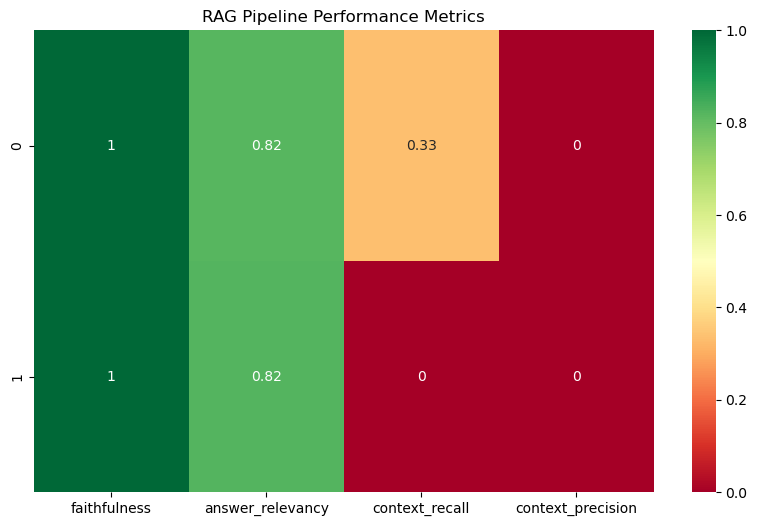

Potential Hallucinations:


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of scores
plt.figure(figsize=(10, 6))
sns.heatmap(df_results.iloc[:, 4:], annot=True, cmap="RdYlGn", vmin=0, vmax=1)
plt.title("RAG Pipeline Performance Metrics")
plt.show()

# Print low-faithfulness examples (Potential Hallucinations)
print("Potential Hallucinations:")
low_faith = df_results[df_results["faithfulness"] < 0.7]
for idx, row in low_faith.iterrows():
    print(f"Q: {row['user_input']}")
    print(f"A: {row['response']}")
    print("---")